In [1]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [2]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [3]:
graph = graph_builder.compile(checkpointer=memory)

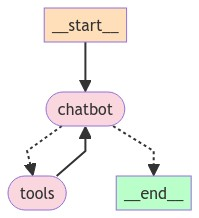

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass


#Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the State as the graph works through each node.

In [5]:
config = {"configurable": {"thread_id": "1"}} #

user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()
    
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
config = {"configurable": {"thread_id": "2"}} #POINTER - DIFFERENT SESSION FOR EACH VALUE FOR THREAD ID

user_input = "Hi my name is mia."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()
    
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()
    
user_input = "who is will"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()
    
    

================================ Human Message =================================

Hi my name is mia.
================================== Ai Message ==================================

Hello Mia! How can I assist you today?
================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Hello Mia! Yes, I remember your name. How can I assist you today?
================================ Human Message =================================

who is will
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bdnSvKJ1sLKIWIh9HZbD3v74)
 Call ID: call_bdnSvKJ1sLKIWIh9HZbD3v74
  Args:
    query: Will
================================= Tool Message =================================
Name: tavily_search_results_json

HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')
=====================

In [ ]:
config = {"configurable": {"thread_id": "3"}} #POINTER - DIFFERENT SESSION FOR EACH VALUE FOR THREAD ID
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': []}, next=(), config={'configurable': {'thread_id': '3'}}, metadata=None, created_at=None, parent_config=None)